In [1]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import shutil
#import evaluate_ate.py # failed because this is implemented in python 2

In [3]:
current_path = os.path.abspath("fbf_eval.ipynb")
data_path = "../Monocular/framebyframeinfo"

In [1]:
# load results
# modify only these 2 lines
dataset_name = "fr3"
blur_level = "0"
# don't change anything after here
# just click "run all"
orb_name = "orb"
gcn_name = "gcn"
orb_test_name = dataset_name+"_"+orb_name+"_"+blur_level #"fr3_orb_0"
gcn_test_name = dataset_name+"_"+gcn_name+"_"+blur_level #"fr3_gcn_0"
current_path = os.path.abspath("eval.ipynb")
project_path = "../GCN2"
# load orb results
orb_result_path = project_path+"/"+orb_test_name
orb_result_path = os.path.join(os.path.dirname(current_path), orb_result_path)
# load gcn results
gcn_result_path = project_path+"/"+gcn_test_name
gcn_result_path = os.path.join(os.path.dirname(current_path), gcn_result_path)
# prepare a directory to save evaluation results
save_path = dataset_name+"_"+blur_level+"_eval"
if not os.path.exists(save_path):
    os.makedirs(save_path)
else:
    shutil.rmtree(save_path) # Removes all the subdirectories!
    os.makedirs(save_path)
    
orb_save_txt = ["Test name: "+orb_test_name]
gcn_save_txt = ["Test name: "+gcn_test_name]

print("Evaluating results from:", dataset_name+"_"+blur_level)

Evaluating results from: fr3_0


In [2]:
def read_number_of_map_points(result_path, save_txt):
    # open total map points file
    with open(result_path+'/MapPointsSave.txt','r') as f_tmp:
        contents_tmp = f_tmp.readlines()

    # total number of map points
    total_number_of_map_points = len(contents_tmp)
    print("Total number of map points:", total_number_of_map_points)
    save_txt.append("Total number of map points: "+ str(total_number_of_map_points))

In [3]:
read_number_of_map_points(orb_result_path, orb_save_txt)
read_number_of_map_points(gcn_result_path, gcn_save_txt)

Total number of map points: 3581
Total number of map points: 5874


In [4]:
def read_frame_by_frame_points(result_path, save_txt):
    # load frame by frame points in the correct order
    FrameByFramePointFiles = sorted(glob.glob(result_path+'/FrameByFramePoints/*.txt'), key=os.path.getmtime)

    total_frame_number = len(FrameByFramePointFiles)
    print("Total number of frames (excluding initialisation): ", total_frame_number)
    save_txt.append("Total number of frames (excluding initialisation): "+ str(total_frame_number))

    # Read all points from all frames
    total_number_of_frame_points = 0
    frame_points = []
    for pointfile in FrameByFramePointFiles:
        # ignore empty files, i.e., frames without points
        filesize = os.path.getsize(pointfile)
        if(filesize == 0):
            continue
        # non-empty files
        with open(pointfile,'r') as f_pt:
            content_pt = f_pt.readlines()
            for pt in content_pt:
                coordinates = pt.replace('[',' ').replace(']',' ').replace(',',' ').split()
                coordinates = np.array(coordinates, dtype=np.float64)
                total_number_of_frame_points += 1
                frame_points.append(coordinates)
    print("average number of feature points detected in each frame: ", 
          int(total_number_of_frame_points/total_frame_number))

    save_txt.append("average number of feature points detected in each frame: "+ 
                    str(int(total_number_of_frame_points/total_frame_number)))

    frame_points = np.asarray(frame_points)
    # remove duplicated points
    # frame_points = np.unique(frame_points, axis=0)
    print("The mean coordinate is: ")
    coordinate_xs = frame_points[:,0]
    coordinate_ys = frame_points[:,1]
    print(np.mean(coordinate_xs), np.mean(coordinate_ys))

    save_txt.append("The mean coordinate is: "+ 
                    str(np.mean(coordinate_xs))+", "+str(np.mean(coordinate_ys)))
    
    return coordinate_xs, coordinate_ys

In [5]:
print("ORB: \n")
orb_xs, orb_ys = read_frame_by_frame_points(orb_result_path, orb_save_txt)
print("\nGCN: \n")
gcn_xs, gcn_ys = read_frame_by_frame_points(gcn_result_path, gcn_save_txt)

ORB: 

Total number of frames (excluding initialisation):  2488
average number of feature points detected in each frame:  303
The mean coordinate is: 
167.64192490459732 113.49189010685679

GCN: 

Total number of frames (excluding initialisation):  2488
average number of feature points detected in each frame:  142
The mean coordinate is: 
154.6995863000591 118.29020628711339


In [6]:
def plot_feature_point_distribution(coordinate_xs,coordinate_ys,test_name,save_txt):
    # plot point distribution
    #plt.scatter(coordinate_xs, coordinate_ys)
    #plt.show()

    # plot point distribution density histogram
    h = plt.hist2d(coordinate_xs, coordinate_ys)
    plt.colorbar(h[3])
    plt.title(test_name+": feature point distribution density")
    plt.savefig(save_path+'/'+test_name+'_feature_point_distribution_density.png')
    plt.show()

    print("The coordinate covariance is: ")
    cov = np.cov(coordinate_xs,coordinate_ys)
    print(cov)
    plt.matshow(cov)
    plt.title(test_name+": feature point covariance")
    plt.savefig(save_path+'/'+test_name+'_feature_point_covariance.png')
    plt.show()
    save_txt.append("The coordinate covariance is: \n"+ str(cov))

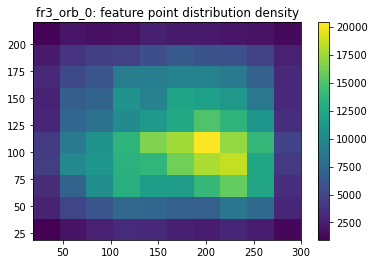

The coordinate covariance is: 
[[4558.8079737   -27.25754626]
 [ -27.25754626 1970.53906374]]


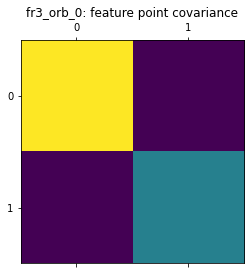

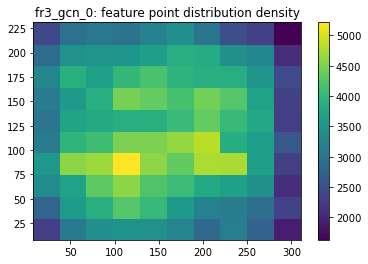

The coordinate covariance is: 
[[6594.82548297   44.83225507]
 [  44.83225507 3716.39600263]]


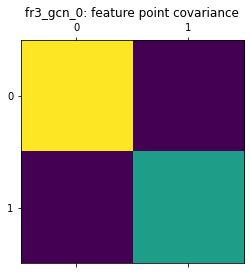

In [7]:
plot_feature_point_distribution(orb_xs, orb_ys, orb_test_name, orb_save_txt)
plot_feature_point_distribution(gcn_xs, gcn_ys, gcn_test_name, gcn_save_txt)

In [5]:
def read_frame_by_frame_info(result_path, data_name="_max_orb"):
    # to draw plots, first load the
    # number of feature points detected in each frame
    # open FrameByFrameInfoSave file: 
    # format: key frames/map points/matches
    all_info = []
    with open(result_path+'/FrameByFrameInfoSave'+data_name+'.txt','r') as f_info:
        contents_info = f_info.readlines()
        for info in contents_info:
            all_info.append(np.array(info.split(), dtype=int))
        all_info = np.asarray(all_info)
        return all_info

In [6]:
max_orb_info = read_frame_by_frame_info(data_path,"_max_orb")
max_gcn_info = read_frame_by_frame_info(data_path,"_max_gcn")
mid_orb_info = read_frame_by_frame_info(data_path,"_mid_orb")


In [11]:
def plot_frame_by_frame_comparison(max_orb_info, max_gcn_info, mid_orb_info):
    # key frame number
    ranges = min(max_gcn_info.shape[0],max_orb_info.shape[0])
    
    plt.plot(range(ranges), max_gcn_info[:ranges,0],label="gcn")
    plt.plot(range(ranges), max_orb_info[:ranges,0],label="orb")
    plt.title("max focal range test"+": key frame number")
    plt.legend()
    plt.xlabel("frame")
    plt.ylabel("key frame number")
    plt.savefig('key_frame_number.png')
    plt.show()

    #if(max_gcn_info.shape[0]==max_orb_info.shape[0]):
        # check if one of them lost track
        # difference number
    #    plt.plot(range(gcn_info.shape[0]), gcn_info[:,0]-orb_info[:,0],label="gcn-orb")
    #    plt.title(dataset_name+"_"+blur_level+": key frame number difference (gcn-orb)")
    #    plt.legend()
    #    plt.xlabel("frame")
    #    plt.ylabel("key frame number (difference)")
    #    plt.savefig(save_path+'/key_frame_number_difference.png')
    #    plt.show()  
    
    # map points number
    plt.plot(range(ranges), max_gcn_info[:ranges,1],label="gcn")
    plt.plot(range(ranges), max_orb_info[:ranges,1],label="orb")
    plt.title("max focal range test"+": map point number")
    plt.legend()
    plt.xlabel("frame")
    plt.ylabel("map point number")
    plt.savefig('map_point_number.png')
    plt.show()

    

    # map points matches number
    plt.plot(range(ranges), max_gcn_info[:ranges,2],label="gcn")
    plt.plot(range(ranges), max_orb_info[:ranges,2],label="orb")
    plt.title("max focal range test"+": matches number")
    plt.legend()
    plt.xlabel("frame")
    plt.ylabel("matches number")
    plt.savefig('matches_number.png')
    plt.show()
    


In [14]:
def plot_mid_orb(mid_orb_info):
    ranges = mid_orb_info.shape[0]
    # key frame number
    plt.plot(range(ranges), max_orb_info[:ranges,0],label="orb")
    plt.title("mid focal range test"+": key frame number")
    plt.legend()
    plt.xlabel("frame")
    plt.ylabel("key frame number")
    plt.savefig('key_frame_number.png')
    plt.show() 
    
    # map points number
    plt.plot(range(ranges), max_orb_info[:ranges,1],label="orb")
    plt.title("mid focal range test"+": map point number")
    plt.legend()
    plt.xlabel("frame")
    plt.ylabel("map point number")
    plt.savefig('map_point_number.png')
    plt.show()

    # map points matches number
    plt.plot(range(ranges), max_orb_info[:ranges,2],label="orb")
    plt.title("mid focal range test"+": matches number")
    plt.legend()
    plt.xlabel("frame")
    plt.ylabel("matches number")
    plt.savefig('matches_number.png')
    plt.show()

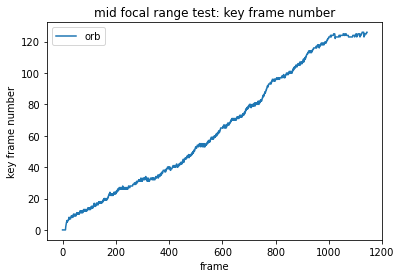

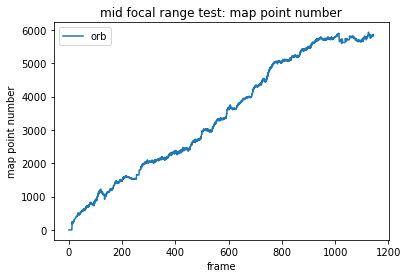

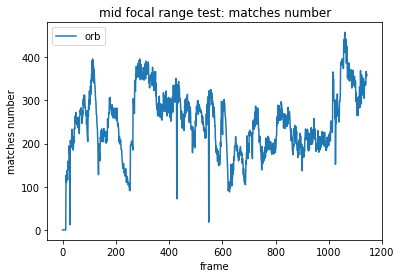

In [15]:
plot_mid_orb(mid_orb_info)

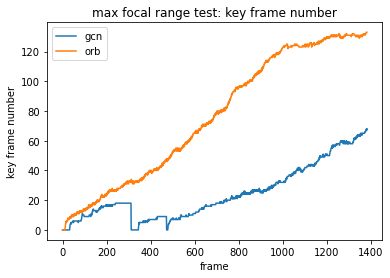

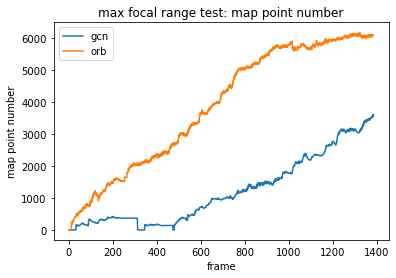

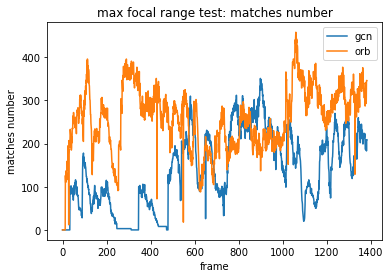

In [12]:
plot_frame_by_frame_comparison(max_orb_info, max_gcn_info, mid_orb_info)

In [12]:
def save_txt(test_name, save_txt):
    # save all outputs in a .txt
    with open(save_path+"/"+test_name+"_eval.txt", "x") as f_eval_txt:
        for txt in save_txt:
            f_eval_txt.write(txt+"\n")

In [13]:
save_txt(orb_test_name, orb_save_txt)
save_txt(gcn_test_name, gcn_save_txt)